We are now going to learn about mixture models; models that combine pieces of several different distributions in intereting ways. These types of models can help with over-dispersion, zero-inflation, and ordered categories.

In [1]:
import sys, re, warnings

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import factorial
import matplotlib.pyplot as plt
import torch
tt =  torch.tensor
from torch.distributions import TransformedDistribution
import pyro
from pyro.distributions import (
    BetaBinomial,
    Binomial,
    Categorical,
    Delta,
    Dirichlet,
    Exponential,
    Gamma,
    GammaPoisson,
    Normal,
    Poisson,
    TorchDistribution,
    TransformedDistribution,
    ZeroInflatedPoisson,
    OrderedLogistic
)
from torch.distributions import Distribution
Distribution.set_default_validate_args(False)

from pyro.distributions.transforms import Transform
from pyro.ops.stats import hpdi, waic, resample
from pyro.infer import Predictive
from pyro.distributions import constraints
import arviz as az 
from utils import train_nuts, unnest_samples, traceplot, precis, plot_intervals, OrderedCategorical#, OrderedTransform

torch.multiprocessing.set_sharing_strategy("file_system")

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 10 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

arviz     : 0.17.1
re        : 2.2.1
pandas    : 2.2.2
pyro      : 1.9.1
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
numpy     : 1.26.4
scipy     : 1.12.0
matplotlib: 3.9.0
torch     : 2.3.0

Watermark: 2.4.3



### Code 12.12 - 12.29
Now we will discuss ordered categorical models. This type of model arises whenever we have a categorical variable that doesn't have a direct numerical interpretation, but nevertheless does have some sort of order (e.g. "worst" < "bad" < "good" < "better" < "best"). We will analyze this in the context of "trolley problems", where someone is placed in a hypothetical situation involving a runaway trolley which will end up killing various people depending on the choices made.

In [3]:
trolley_df = pd.read_csv("data/Trolley.csv", sep=";")
print(len(trolley_df), "rows")
trolley_df[["story", "age", "male", "edu", "action", "intention", "contact", "response"]].sample(6)

9930 rows


story  age  male                edu  action  intention  contact  response
5310   aqu   23     1  Bachelor's Degree       0          0        1         5
7251   shi   14     1      Middle School       1          1        0         3
5531   spe   32     1  Bachelor's Degree       1          0        0         2
3220   car   24     0  Bachelor's Degree       1          0        0         4
9178   swi   36     1  Bachelor's Degree       0          1        0         3
3873   box   37     0       Some College       0          1        1         1

In order to enforce the ordering of the response variables (so that increasing one of the associated predictor variables increases the response), we will use a cumulative link function. Basically, each outcome level gets its own "intercept" $\alpha_k$ that is related to the cumulative probability via
$$
\log\left(\frac{Pr(y_i \le k)}{1 - Pr(y_i \le k)}\right) = \alpha_k
$$
You will notice that this is the logit function, so its inverse is the sigmoid $Pr(y_i \le k) = \sigma(\alpha_k) = e^{\alpha_k}/(1+e^{\alpha_k})$. The idea is that as we introduce predictor variables, we add them onto $\alpha_k$ as a linear model, then do the sigmoid thing to convert them into cumulative

/tmp/ipykernel_14757/432392252.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, np.log(y/(1-y)), marker="o")


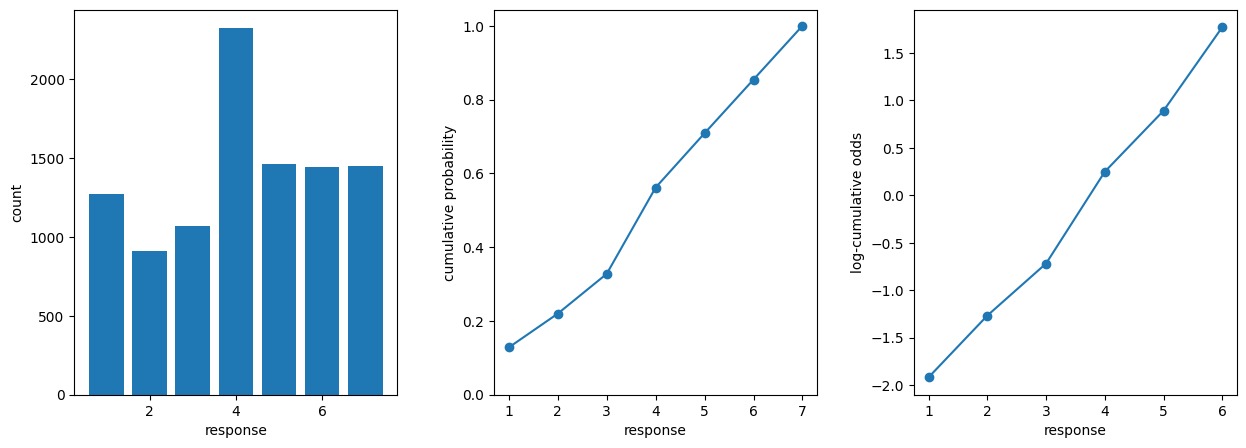

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
plt.sca(axes[0])
x, y = np.unique(trolley_df["response"], return_counts=True)
plt.bar(x, y)
plt.xlabel("response")
plt.ylabel("count")
plt.sca(axes[1])
y = np.cumsum(y)/y.sum()
plt.plot(x, y, marker="o")
plt.xlabel("response")
plt.ylabel("cumulative probability")
plt.ylim(bottom=0)
plt.sca(axes[2])
plt.plot(x, np.log(y/(1-y)), marker="o")
plt.xlabel("response")
plt.ylabel("log-cumulative odds")
plt.subplots_adjust(wspace=0.3)
plt.show()

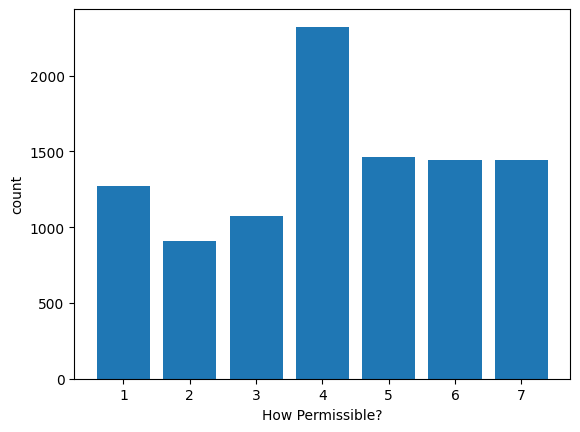

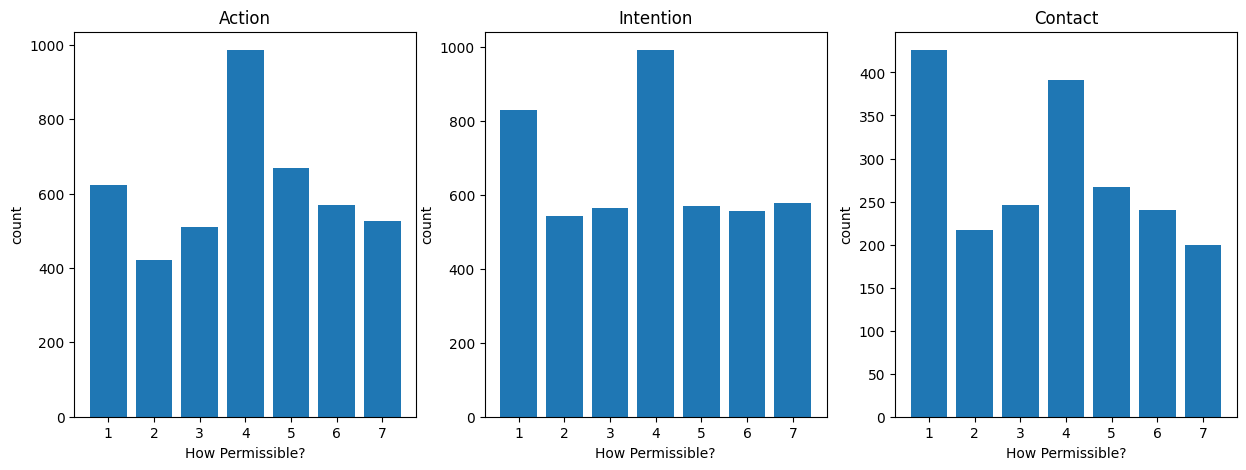

In [5]:
x, y = np.unique(trolley_df["response"], return_counts=True)
plt.bar(x, y)
plt.xlabel("How Permissible?")
plt.ylabel("count")
plt.show()

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
plt.sca(axes[0])
x, y = np.unique(trolley_df[trolley_df["action"]==1]["response"], return_counts=True)
plt.bar(x, y)
plt.xlabel("How Permissible?")
plt.ylabel("count")
plt.title("Action")

plt.sca(axes[1])
x, y = np.unique(trolley_df[trolley_df["intention"]==1]["response"], return_counts=True)
plt.bar(x, y)
plt.xlabel("How Permissible?")
plt.ylabel("count")
plt.title("Intention")

plt.sca(axes[2])
x, y = np.unique(trolley_df[trolley_df["contact"]==1]["response"], return_counts=True)
plt.bar(x, y)
plt.xlabel("How Permissible?")
plt.ylabel("count")
plt.title("Contact")
plt.show()

/tmp/ipykernel_14757/3601473259.py:3: RuntimeWarning: divide by zero encountered in divide
  x = np.log(y/(1-y))


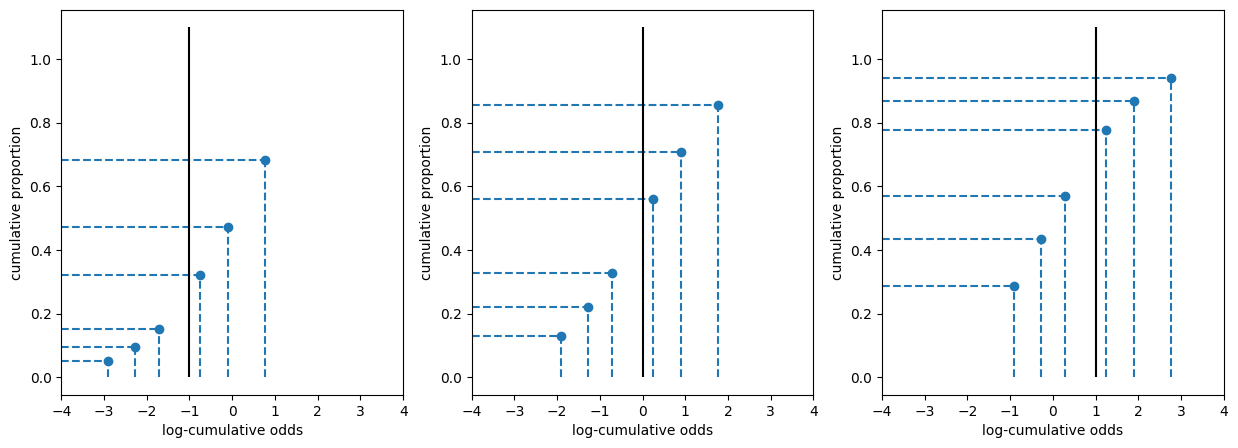

In [6]:
x, y = np.unique(trolley_df["response"], return_counts=True)
y = np.cumsum(y)/y.sum()
x = np.log(y/(1-y))
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
plt.sca(axes[1])
plt.stem(x, y, linefmt='--')
plt.ylabel("cumulative proportion")
plt.xlabel("log-cumulative odds")
plt.xlim(-4, 4)
for i in range(len(x)):
    plt.hlines(y[i], -4, x[i],  ls="--")
plt.vlines(0, 0, 1.1, ls="-", color="k")

plt.sca(axes[2])
x = x + 1
y = torch.sigmoid(tt(x))
plt.stem(x, y, linefmt='--')
plt.ylabel("cumulative proportion")
plt.xlabel("log-cumulative odds")
plt.xlim(-4, 4)
for i in range(len(x)):
    plt.hlines(y[i], -4, x[i],  ls="--")
plt.vlines(1, 0, 1.1, ls="-", color="k")

plt.sca(axes[0])
x = x -2
y = torch.sigmoid(tt(x))
plt.stem(x, y, linefmt='--')
plt.ylabel("cumulative proportion")
plt.xlabel("log-cumulative odds")
plt.xlim(-4, 4)
for i in range(len(x)):
    plt.hlines(y[i], -4, x[i],  ls="--")
plt.vlines(-1, 0, 1.1, ls="-", color="k")
plt.show()


As part of inference, we will need the likelihood of getting a particular response $Pr(y_i = k)$. If we have the cumulative probability, then this is simply
$$
p_k = Pr(y_i = k) = Pr(y_i \le k) - Pr(y_i \le k-1) = \sigma(\alpha_k) - \sigma(\alpha_{k-1})
$$

This implies a model such as
$$\begin{align}
R_i &\sim \text{Categorial}(\boldsymbol{p}) \\
p_0 &= q_0 \\
p_k &= q_k - q_{k-1} \qquad 2 < k < K-1 \\
p_{K-1} &= 1 - q_{K-1} \\
q_k &= \sigma(\alpha_k - \phi_i) \\
\phi_i &= \text{some kind of (linear?) model of predictor variables} \\
\alpha_k &\sim \text{Normal}(0, 1.5)
\end{align}$$

$$\begin{align}
R_i &\sim \text{OrderedLogit}(\boldsymbol{\phi_i, \alpha}) \\
\phi_i &= 0\\
\beta_{\_} &= \text{Normal}(0, 0.5)\\
\alpha_j &\sim \text{Normal}(0, 1)
\end{align}$$

In [7]:
data = {
    "num_levels": trolley_df["response"].nunique(),
    "num_rows": len(trolley_df),
    "response": tt(trolley_df["response"].values-1).double(),
}

In [8]:
def model_m12_5(data, training=False):
    N = data["num_rows"]
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(1.0, 5.0).expand([K-1]).to_event(0))
    phi = torch.zeros_like(data["response"])
    if training:
        # OrderedCategorical
        pyro.sample("R", OrderedCategorical(phi, cutpoints), obs=data["response"])
    else:
        return pyro.sample("R", OrderedCategorical(phi, cutpoints))

In [9]:
m12_5 = train_nuts(model_m12_5, data, 1000, 5000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 6000/6000 [00:44, 133.65it/s, step size=6.46e-01, acc. prob=0.909]


In [10]:
m12_5.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
cutpoints[0]     -1.92      0.03     -1.92     -1.96     -1.87   7367.09      1.00
cutpoints[1]     -2.01      0.03     -2.01     -2.06     -1.95   6332.66      1.00
cutpoints[2]     -1.58      0.03     -1.58     -1.63     -1.53   7045.42      1.00
cutpoints[3]     -0.23      0.03     -0.23     -0.27     -0.19   5733.10      1.00
cutpoints[4]      0.14      0.03      0.14      0.09      0.20   5574.73      1.00
cutpoints[5]      1.23      0.04      1.23      1.17      1.30   5456.23      1.00

Number of divergences: 0


/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([[<Axes: title={'center': 'cutpoints\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'cutpoints\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'cutpoints\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'cutpoints\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'cutpoints\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'cutpoints\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

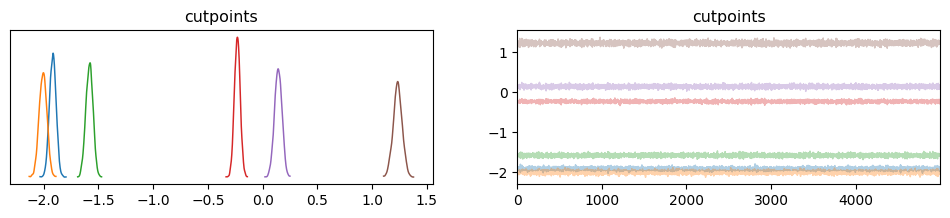

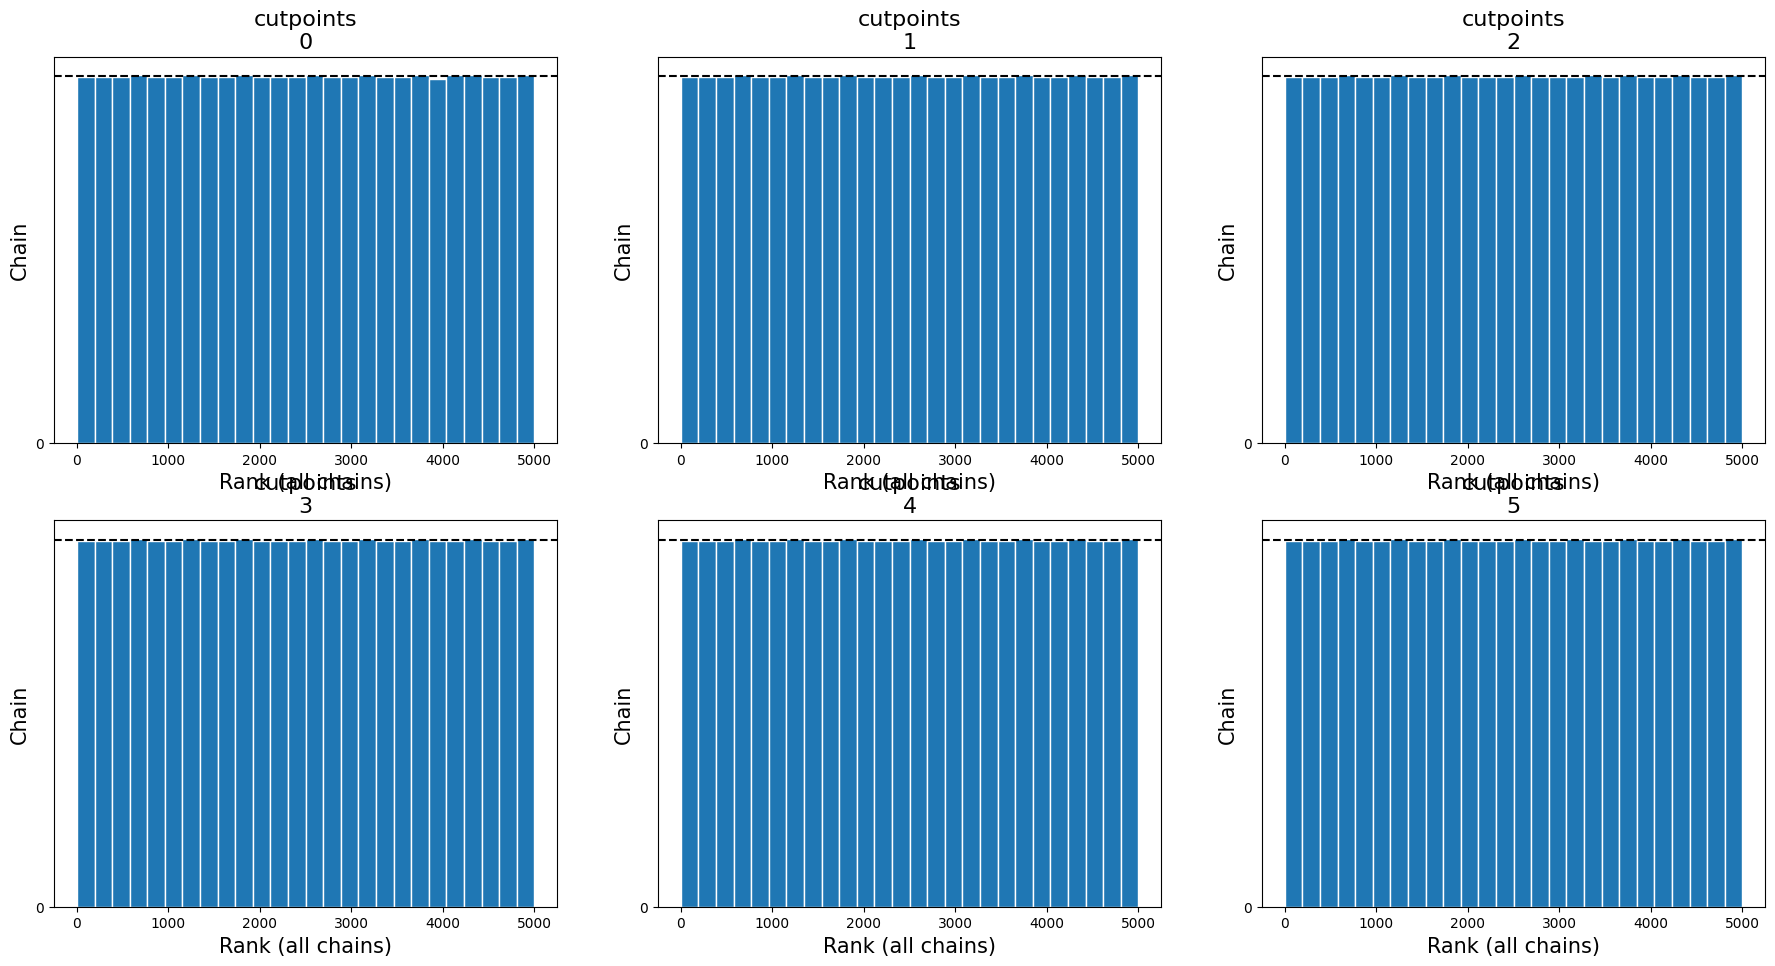

In [11]:
az.plot_trace(az.from_pyro(m12_5))
az.plot_rank(az.from_pyro(m12_5))

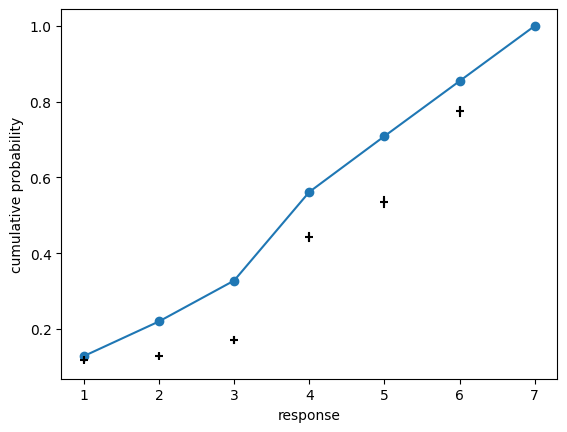

In [12]:
# plot data
x, y = np.unique(trolley_df["response"], return_counts=True)
y = np.cumsum(y)/y.sum()
plt.plot(x, y, marker="o")
# plot inferred values
s = m12_5.get_samples()
s["cutpoints"] = torch.sort(s["cutpoints"], dim=1).values
s["cum_p"] = torch.sigmoid(s["cutpoints"])
q = hpdi(s["cum_p"], 0.89, dim=0)
mean = s["cum_p"].mean(dim=0)
for i in x[:-1]:
    plt.plot([i, i], q[:,i-1], color="black")
    plt.scatter(i, mean[i-1], color="black", marker="+", zorder=100)
plt.xlabel("response")
plt.ylabel("cumulative probability")
plt.show()

The order of the cutpoints are all jumbled (we can sort after the fact), but they agree with the values in the text, and the values we computed earlier. Now, it's great that we now have all these cutpoints, but all we have now is essentially just a Bayesian version of a histogram (though the error bars, given by the + symbols, are extremely small). Next, we'll add our linear model $\phi_i$.

The model is given by
$$\begin{align}
R_i &\sim \text{OrderedLogit}(\boldsymbol{\phi_i, \alpha}) \\
\phi_i &= \beta_A A_i + \beta_C C_i + \beta_I I_i \\
\beta_{\_} &= \text{Normal}(0, 0.5)\\
\alpha_j &\sim \text{Normal}(0, 1)
\end{align}$$

$$\begin{align}
R_i &\sim \text{OrderedLogit}(\boldsymbol{\phi_i, \alpha}) \\
\phi_i &= \beta_A A_i + \beta_C C_i + B_{I,i}I_i \\
B_{I,i} &= \beta_I + \beta_{IA} A_i + \beta_{IC} C_i\\
\beta_{\_} &= \text{Normal}(0, 0.5)\\
\alpha_j &\sim \text{Normal}(0, 1)
\end{align}$$


$A$, $C$ and $I$ are the presence of "action", "contact", and "intention" in each of the trolley problem descriptions, and we want to see if some combination of them will lead to changes in the way the trolley problem is interpreted. We can see that there are interaction effects through the term $B_{I,i}$. Notably, we exclude an interaction term of the form $C_i A_i$ because contact precludes action.

In [13]:
trolley_df.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

In [14]:
data = {
    "num_levels": trolley_df["response"].nunique(),
    "num_rows": len(trolley_df),
    "response": tt(trolley_df["response"].values-1).double(),
    "action": tt(trolley_df["action"].values).long(),
    "intention": tt(trolley_df["intention"].values).long(),
    "contact": tt(trolley_df["contact"].values).long(),
}

In [15]:
def model_m12_6(data, training=False):
    N = data["num_rows"] 
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(0., 1.0).expand([K-1]).to_event(0))
    A, I, C = [data[k] for k in ("action", "intention", "contact")]
    b = {k: pyro.sample("b"+k, Normal(0., 0.5)) for k in ("A","C","I")}
    phi = (b["A"]*A + b["C"]*C + b["I"]*I)
    if training:
        pyro.sample("R", OrderedCategorical(phi, cutpoints), obs=data["response"])
    else:
        return pyro.sample("R", OrderedCategorical(phi, cutpoints))

In [16]:
def model_m12_6(data, training=False):
    N = data["num_rows"] #data["response"].shape[0]
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(0., 1.0).expand([K-1]).to_event(0))
    A, I, C = [data[k] for k in ("action", "intention", "contact")]
    b = {k: pyro.sample("b"+k, Normal(0., 0.5)) for k in ("A","C","I","IC","IA")}
    BI = b["I"] + b["IA"]*A + b["IC"]*C
    phi = (b["A"]*A + b["C"]*C + BI*I)
    if training:
        pyro.sample("R", OrderedCategorical(phi, cutpoints), obs=data["response"])
    else:
        return pyro.sample("R", OrderedCategorical(phi, cutpoints))

In [17]:
m12_6 = train_nuts(model_m12_6, data, 1000, 3000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 4000/4000 [01:20, 49.89it/s, step size=3.18e-01, acc. prob=0.900]


In [18]:
m12_6.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          bA     -0.46      0.06     -0.46     -0.56     -0.38    625.68      1.00
          bC     -0.33      0.07     -0.33     -0.45     -0.22    811.75      1.00
          bI     -0.28      0.06     -0.28     -0.38     -0.19    624.56      1.00
         bIA     -0.44      0.08     -0.44     -0.57     -0.31    852.60      1.00
         bIC     -1.25      0.10     -1.25     -1.41     -1.09    994.33      1.00
cutpoints[0]     -2.62      0.05     -2.62     -2.70     -2.53    634.93      1.00
cutpoints[1]     -2.62      0.05     -2.61     -2.70     -2.52    685.03      1.00
cutpoints[2]     -2.13      0.05     -2.13     -2.22     -2.05    651.50      1.00
cutpoints[3]     -0.74      0.05     -0.74     -0.81     -0.66    569.46      1.00
cutpoints[4]     -0.34      0.05     -0.34     -0.43     -0.26    679.57      1.00
cutpoints[5]      0.76      0.05      0.76      0.68      0.85    727.26      1.00

Nu

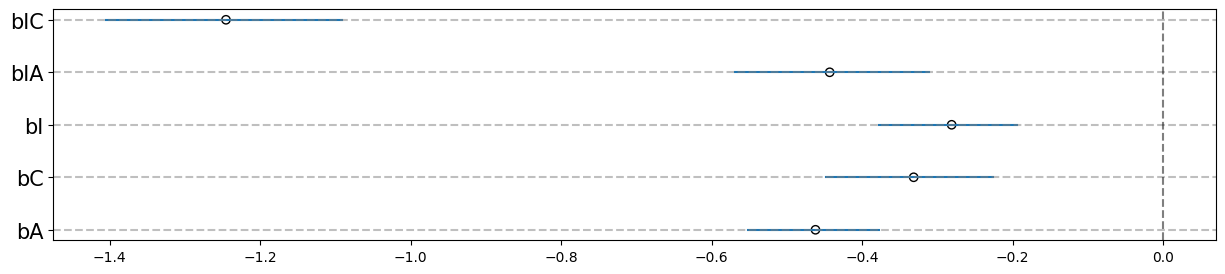

In [19]:
samples = m12_6.get_samples()
s = {k: v.numpy() for k, v in samples.items() if k != "cutpoints"}
plt.figure(figsize=(15, 3))
plot_intervals(s, 0.89); plt.show()

Interesting... so the presence of any of action, contact or intent causes mild reduction in response (as well as the combo of intent/action), but the combination of intent and contact (e.g. intentionally trying to injure someone, for example) REALLY makes pulling the lever morally questionable. Perhaps not terribly surprising when you think about it, but now we have statistical evidence to support it!

Let's do some more visualization. First I'll make some plots showing how the cumulative probabilities change as we change the predictor variables. In particular, how do they change if we switch intention from 0 to 1?

In [20]:
def model_m12_6(data, training=False):
    N = data["num_rows"] #data["response"].shape[0]
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(0., 1.).expand([K-1]).to_event(0))
    A, I, C = [data[k] for k in ("action", "intention", "contact")]
    b = {k: pyro.sample("b"+k, Normal(0., 0.5)) for k in ("A","C","I","IC","IA")}
    BI = b["I"] + b["IA"]*A + b["IC"]*C
    phi = b["A"]*A + b["C"]*C + BI*I
    dist = OrderedCategorical(phi, cutpoints)
    pyro.deterministic("q", dist.cum_prob)
    if training:
        pyro.sample("R", dist, obs=data["response"])
    else:
        return pyro.sample("R", dist)


In [21]:
m12_6 = train_nuts(model_m12_6, data, 300, 1000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 1300/1300 [00:27, 47.43it/s, step size=3.45e-01, acc. prob=0.896]


In [22]:
m12_6.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          bA     -0.46      0.05     -0.46     -0.53     -0.36    195.64      1.00
          bC     -0.33      0.07     -0.33     -0.45     -0.22    210.85      1.00
          bI     -0.28      0.06     -0.28     -0.37     -0.19    175.14      1.00
         bIA     -0.44      0.08     -0.44     -0.57     -0.31    197.30      1.00
         bIC     -1.25      0.09     -1.25     -1.39     -1.09    242.51      1.00
cutpoints[0]     -2.62      0.05     -2.62     -2.72     -2.55    205.82      1.01
cutpoints[1]     -2.61      0.06     -2.62     -2.70     -2.52    235.90      1.00
cutpoints[2]     -2.13      0.05     -2.13     -2.21     -2.05    218.03      1.00
cutpoints[3]     -0.74      0.05     -0.74     -0.81     -0.66    185.43      1.00
cutpoints[4]     -0.34      0.05     -0.34     -0.43     -0.26    217.38      1.00
cutpoints[5]      0.76      0.06      0.76      0.66      0.84    233.85      1.00

Nu

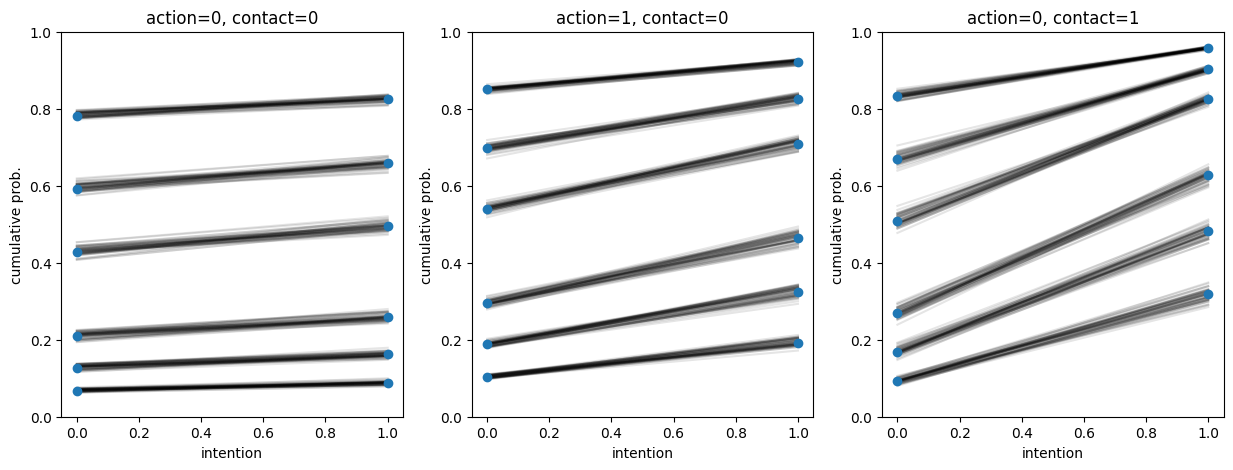

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
d = dict(intention=tt([0., 1.]), num_rows=2, num_levels=7)
for (a, c), ax in zip(((0., 0.), (1., 0.), (0., 1.)), axes):
    plt.sca(ax)
    d["action"] = tt([a, a])
    d["contact"] = tt([c, c])
    samples = {k: v.squeeze() for k, v in Predictive(model_m12_6, m12_6.get_samples(), return_sites=("q","R"))(d).items()}
    mean = samples["q"].mean(dim=0)
    for i in range(samples["q"].shape[-1]):
        plt.scatter([0, 1], mean[:,i], color="C0")
        for s in range(50):
            plt.plot([0, 1], samples["q"][s,:,i], color="black", alpha=0.1, zorder=-1)
    plt.xlabel("intention")
    plt.ylabel("cumulative prob.")
    plt.ylim(bottom=0, top=1)
    plt.title(f"action={int(a)}, contact={int(c)}")

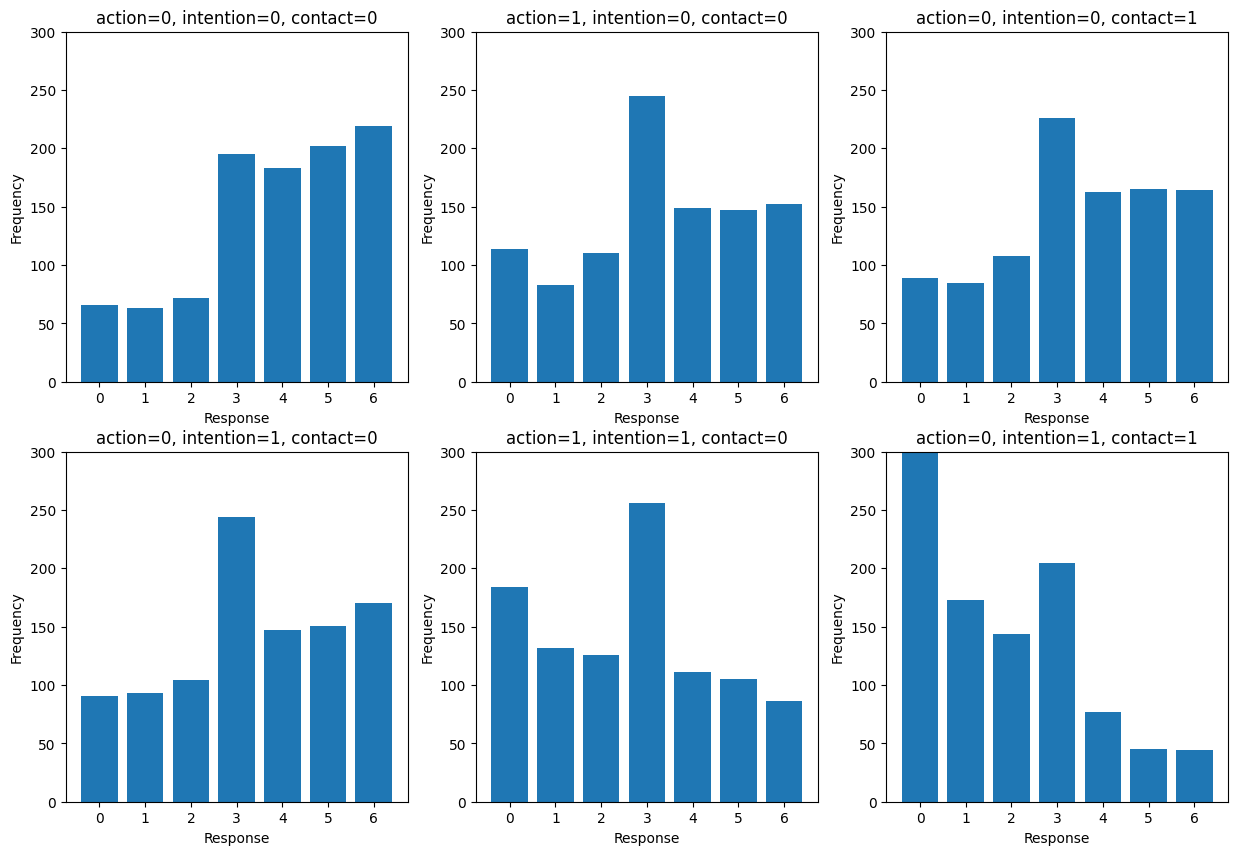

In [24]:
# plot predictive distribution for each treatment
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
l = (((0,0,0), (1,0,0), (0,0,1)), ((0,1,0), (1,1,0), (0,1,1)))
R = {}
for row1,ax1 in zip(l, axes):
    for (a,b,c),ax in zip(row1, ax1):
        plt.sca(ax)
        d = dict(intention=tt([b]), num_rows=1, num_levels=7)
        d["action"] = tt([a])
        d["contact"] = tt([c])
        samples = {k: v.squeeze() for k, v in Predictive(model_m12_6, m12_6.get_samples(), return_sites=("q","R"))(d).items()}
        R[(a,b,c)] = samples["R"]
        x, y = np.unique(samples["R"], return_counts=True)
        plt.bar(x,y)
        plt.title(f"action={int(a)}, intention={int(b)}, contact={int(c)}")
        plt.xlabel("Response")
        plt.ylabel("Frequency")
        plt.ylim(0, 300)


### Code 12.30 - 12.??
Now that we've explored ordered categorical response variables, what do we do about ordered predictor variables? These are what we would have as _input_ to the model rather than _output_. We will explore this through the `edu` variable in the trolley dataset, which describes the highest level of education attained by the subject.

In [25]:
trolley_df["edu"].unique()

array(['Middle School', "Bachelor's Degree", 'Some College',
       "Master's Degree", 'High School Graduate', 'Graduate Degree',
       'Some High School', 'Elementary School'], dtype=object)

There are 8 different levels, so we will need to encode them in the proper order.

In [26]:
trolley_df["edu_levels"] = trolley_df["edu"].map({k: i for i, k in enumerate([
    "Elementary School", "Middle School", "Some High School", "High School Graduate",
    "Some College", "Bachelor's Degree", "Master's Degree", "Graduate Degree"
])})
trolley_df["edu_levels"].sample(10)

2421    6
7965    5
9367    5
5112    5
2083    5
9167    5
3331    6
6134    4
5486    6
2479    5
Name: edu_levels, dtype: int64

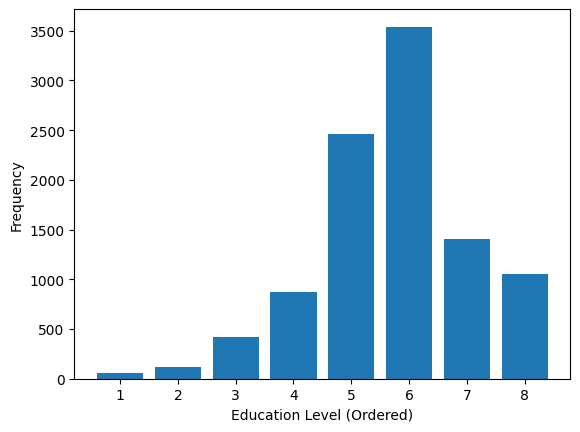

In [27]:
x, y = np.unique(trolley_df["edu_levels"], return_counts=True)
plt.bar(x+1, y)
plt.xlabel("Education Level (Ordered)")
plt.ylabel("Frequency")
plt.show()

$$\begin{align}
\phi_i &= 0\\
\phi_i &= \delta_1 \\
\phi_i &= \delta_1  + \delta_2 \\
\phi_i &= \delta_1  + \delta_2 + \delta_3\\
\phi_i &= \delta_1  + \delta_2 + \delta_3  + \delta_4\\
\phi_i &= \delta_1  + \delta_2 + \delta_3  + \delta_4 + \delta_5\\
\phi_i &= \delta_1  + \delta_2 + \delta_3  + \delta_4 + \delta_5 + \delta_6\\
\phi_i &= \delta_1  + \delta_2 + \delta_3  + \delta_4 + \delta_5 + \delta_6 + \delta_7 = \beta_E
\end{align}$$

$$\begin{align}
1 \; (elementary) &\\
2 \; (middle school) &\\
3 \; (some high school) &\\
4 \; (high school) &\\
5 \; (some college) &\\
6 \; (college) &\\
7 \; (master's) &\\
8 \; (doctorate) &
\end{align}$$

The way we account for this mathematically is to introduce several variables $\delta_i$ (one for each level of the predictor minus one; the first can be absorbed into the intercept) to represent the incremental effect of each level of the predictor, like so:
$$
\phi_i = \sum_{j=0}^{E_i-1} \delta_j + \text{other terms...}
$$
where $E_i$ is the educational level of data point $i$. The text recommends adding a simplex constraint to the $\delta_i$'s (they are positive and sum to one), and extracting the overall sum as a separate variable $\beta_E$:
$$
\phi_i = \beta_E \sum_{j=0}^{E_i-1} \delta_j + \text{other terms...}
$$

So now this piece of our model can be combined with some of the other terms from before to get
$$\begin{align}
R_i &\sim \text{Ordered-logit}(\phi_i, \kappa) \\
\phi_i &= \beta_E \sum_{j=0}^{E_i-1} \delta_j + \beta_A A_i + \beta_I I_i + \beta_C C_i \\
\kappa_k &\sim \text{Normal}(0, 1.0) \\
\beta_E, \beta_A, \beta_I, \beta_C &\sim \text{Normal}(0, 0.5) \\
\delta &\sim \text{Dirichlet}(\alpha)
\end{align}$$
I guess we're neglecting the interaction between $I$ and the other problem type variables. The Dirichlet distribution we haven't seen thus far in the book, so it needs introducing. It's essentially a generalization of the beta distribution. Recall the beta is a distribution for a single probability parameter $p$. Now imagine that it also implictly defines the distribution for the _complement_ to that probability, $1-p$. Together, these two probability masses sum to unity ($p + (1-p) = 1$). Now imagine that instead of just two probabilities $p_1 = p$ and $p_2 = 1-p$, there are $N$ different probabilities that all sum to unity $\sum_{i=1}^N p_i = 1$ (also known as the _simplex_ constraint). The Dirichlet is one distribution that satisfies this constraint. The hyperparameter $\alpha$ is a vector of real numbers that can be thought of as (pseudo-)counts of events belonging to a category (i.e. $\alpha_i$ is the count of events observed belonging to category $i$)

In [28]:

data = {
    "num_levels": trolley_df["response"].nunique(),
    "num_rows": len(trolley_df),
    "response": tt(trolley_df["response"].values-1).double(),
    "action": tt(trolley_df["action"].values).long(),
    "intention": tt(trolley_df["intention"].values).long(),
    "contact": tt(trolley_df["contact"].values).long(),
    "edu": tt(trolley_df["edu_levels"].values).long(),
}
data["mask"] = (torch.arange(7)[None,:] < data["edu"][:,None])

In [29]:
def model_m12_7(data, training=False):
    N = data["num_rows"]
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(-1.5, 1.5).expand([K-1]).to_event(0))
    A, I, C = [data[k] for k in ("action", "intention", "contact")]
    b = {k: pyro.sample("b"+k, Normal(0., 1.)) for k in ("A","C","I","E")}
    d = pyro.sample("delta", Dirichlet(tt(7*[2.])))
    a = pyro.sample("a", Normal(0., 1.))
    phi = a + (b["A"]*A + b["C"]*C + b["I"]*I) + b["E"]*(d[None,:]*data["mask"]).sum(dim=1)
    dist = OrderedCategorical(phi, cutpoints)
    if training:
        pyro.sample("R", dist, obs=data["response"])
    else:
        return pyro.sample("R", dist)

In [30]:
m12_7 = train_nuts(model_m12_7, data, 2000, 3000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/5000 [00:00, ?it/s]/tmp/ipykernel_14757/2122203059.py:7: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  d = pyro.sample("delta", Dirichlet(tt(7*[2.])))
Sample: 100%|██████████| 5000/5000 [20:07,  4.14it/s, step size=2.81e-02, acc. prob=0.931]


In [31]:
m12_7.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
           a      0.25      0.52      0.24     -0.54      1.18    634.30      1.00
          bA     -0.71      0.04     -0.71     -0.77     -0.64   2668.76      1.00
          bC     -0.96      0.05     -0.96     -1.04     -0.88   2438.72      1.00
          bE     -0.41      0.20     -0.38     -0.72     -0.10   1633.83      1.00
          bI     -0.72      0.04     -0.72     -0.78     -0.65   3396.23      1.00
cutpoints[0]     -2.91      0.50     -2.93     -3.61     -1.95    588.57      1.00
cutpoints[1]     -2.93      0.50     -2.94     -3.71     -2.05    591.90      1.00
cutpoints[2]     -2.46      0.50     -2.48     -3.20     -1.54    593.68      1.00
cutpoints[3]     -1.07      0.50     -1.08     -1.81     -0.14    590.09      1.00
cutpoints[4]     -0.67      0.50     -0.68     -1.45      0.23    590.33      1.00
cutpoints[5]      0.44      0.50      0.42     -0.35      1.31    593.75      1.00
   

It might not seem like it, but this last model took forever to figure out. The problem was that I was _sorting_ the cutpoints before passing them to the ordered logit model, and this was causing an identification problem, because the cutpoints were therefore permutation invariant. So the MCMC chain was jumping around from cutpoint to cutpoint without settling down. The solution to this was pretty simple; exponentiate the cutpoints (so that they were all positive), then take the cumulative sum (so that the output was in increasing order), then take the log (a monotonic transformation to try and undo the explosive effect of exponentiation). This seems to have had pretty good results, as you can see below; the cutpoints now seem to be decently well-separated.

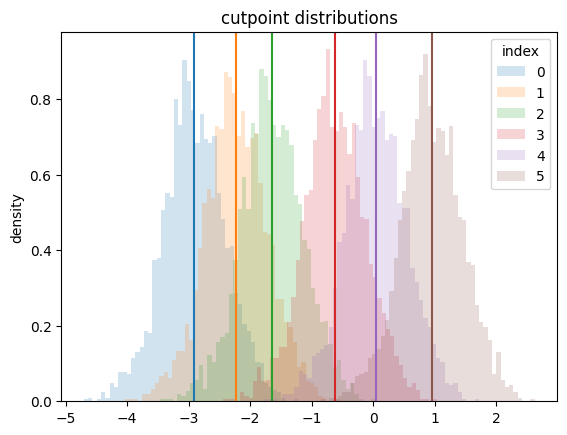

In [32]:
samples = m12_7.get_samples()
v = samples["cutpoints"].exp().cumsum(-1).log()
for i in range(v.shape[-1]):
    plt.hist(v[:,i], bins=50, label=i, alpha=0.2, histtype="stepfilled", density=True)
    plt.axvline(v[:,i].mean(), color=f"C{i}")
plt.legend(title="index")
plt.title("cutpoint distributions")
plt.ylabel("density")
plt.show()

However, the marginal distributions are kind of misleading, because if we look at the joint distributions, we can see that they are _highly_ correlated! So if one cutpoint is higher than its mean, this cascades to all other cutpoints, which shift upward by a similar amount... what might be causing this? Perhaps, it is the presence of the intercept `a` in the linear model `phi`! Looking at its joint distribution with the cutpoints, we can see that it is also highly correlated with all of them! So what if we just get rid of it and deal directly with the cutpoints?

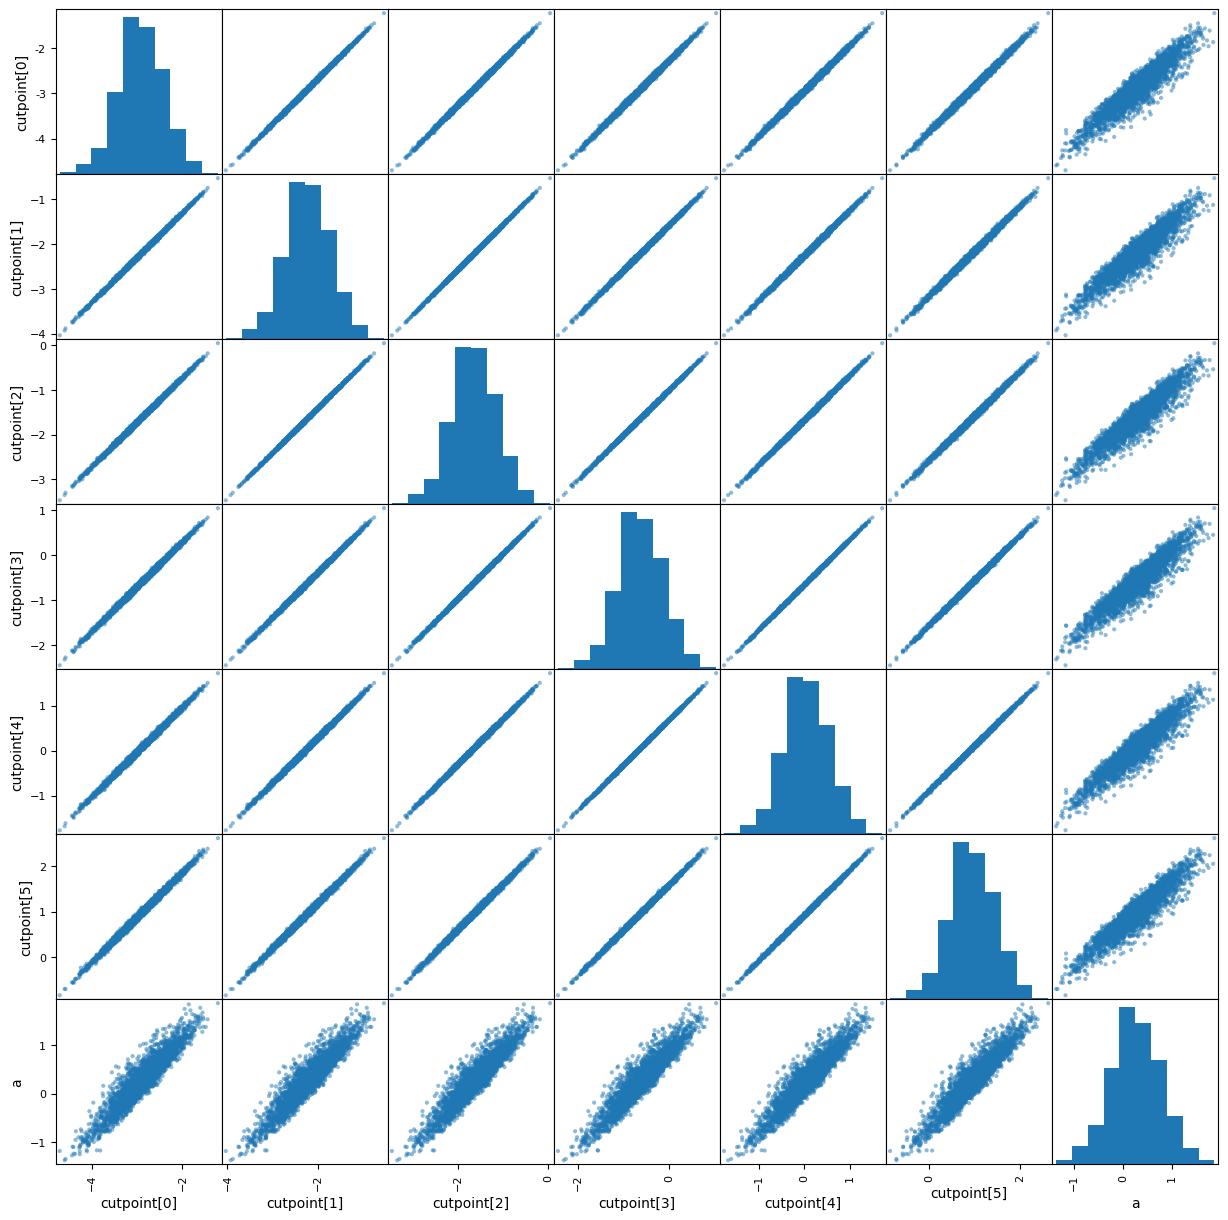

In [33]:
df = pd.DataFrame(
    data=torch.cat([v, samples["a"][:,None]], dim=-1).numpy(),
    columns=[f"cutpoint[{i}]" for i in range(v.shape[-1])] + ["a"]
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

In [34]:
def model_m12_7(data, training=False):
    N = data["num_rows"]
    K = data["num_levels"]
    cutpoints = pyro.sample("cutpoints", Normal(-1.5, 1.5).expand([K-1]).to_event(0))
    A, I, C = [data[k] for k in ("action", "intention", "contact")]
    b = {k: pyro.sample("b"+k, Normal(0., 1.)) for k in ("A","C","I","E")}
    d = pyro.sample("delta", Dirichlet(tt(7*[2.])))
    phi = (b["A"]*A + b["C"]*C + b["I"]*I) + b["E"]*(d[None,:]*data["mask"]).sum(dim=1)
    if training:
        pyro.sample("R", OrderedCategorical(phi, cutpoints), obs=data["response"])
    else:
        return pyro.sample("R", OrderedCategorical(phi, cutpoints))

In [35]:
m12_7 = train_nuts(model_m12_7, data, 2000, 3000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/5000 [00:00, ?it/s]/tmp/ipykernel_14757/4081555947.py:7: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  d = pyro.sample("delta", Dirichlet(tt(7*[2.])))
Sample: 100%|██████████| 5000/5000 [06:40, 12.48it/s, step size=9.42e-02, acc. prob=0.919]


OK, that completed MUCH faster than the original run, and I think if you look at the summary/plots below, it is clear that the results are much more significant, and do not suffer from the non-identifiability problem that was troubling us before. The cutpoints are still pretty highly correlated, but not nearly as much as before. If we look at the traceplot/scatterplot, it seems that the education level coefficient $\beta_E$ is also highly correlated with the cutpoints!

In [36]:
m12_7.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          bA     -0.71      0.04     -0.71     -0.78     -0.64   1837.79      1.00
          bC     -0.96      0.05     -0.96     -1.04     -0.87   1859.23      1.00
          bE     -0.38      0.18     -0.37     -0.67     -0.09    639.56      1.00
          bI     -0.72      0.04     -0.72     -0.78     -0.66   2799.16      1.00
cutpoints[0]     -3.14      0.17     -3.12     -3.41     -2.88    600.39      1.00
cutpoints[1]     -3.16      0.17     -3.14     -3.40     -2.88    614.03      1.00
cutpoints[2]     -2.69      0.17     -2.68     -2.94     -2.42    607.42      1.00
cutpoints[3]     -1.30      0.17     -1.28     -1.55     -1.03    607.93      1.00
cutpoints[4]     -0.90      0.16     -0.89     -1.15     -0.63    607.48      1.00
cutpoints[5]      0.20      0.17      0.22     -0.04      0.48    608.45      1.00
    delta[0]      0.26      0.15      0.24      0.03      0.49    949.92      1.00
   

$\beta_E$ is not interpretable because of collider path

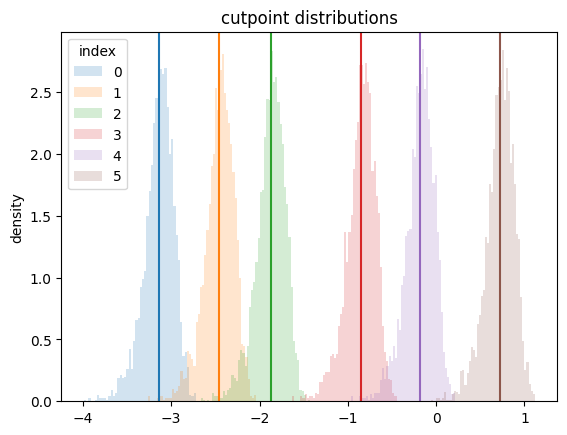

In [37]:
samples = m12_7.get_samples()
v = samples["cutpoints"].exp().cumsum(-1).log()
for i in range(v.shape[-1]):
    plt.hist(v[:,i], bins=50, label=i, alpha=0.2, histtype="stepfilled", density=True)
    plt.axvline(v[:,i].mean(), color=f"C{i}")
plt.legend(title="index")
plt.title("cutpoint distributions")
plt.ylabel("density")
plt.show()

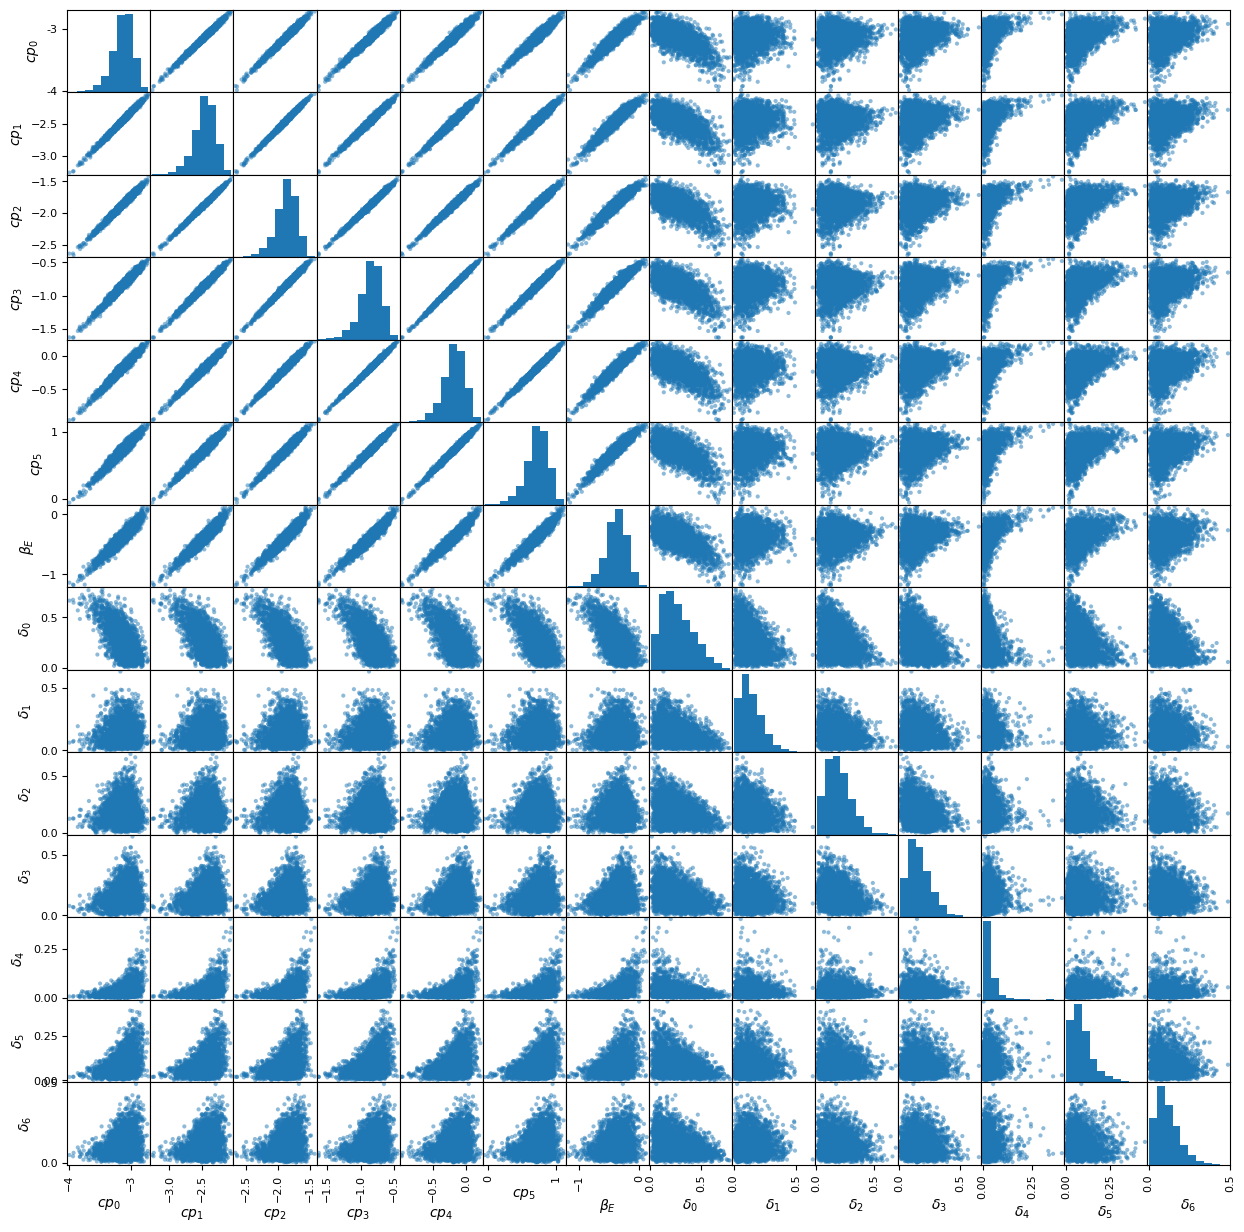

In [38]:
d = samples["delta"]
df = pd.DataFrame(
    data=torch.cat([v, samples["bE"][:,None], d], dim=-1).numpy(),
    columns=[fr"$cp_{i}$" for i in range(v.shape[-1])] + [r"$\beta_E$"] + [fr"$\delta_{i}$" for i in range(d.shape[-1])]
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([[<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'bC'}>, <Axes: title={'center': 'bC'}>],
       [<Axes: title={'center': 'bE'}>, <Axes: title={'center': 'bE'}>],
       [<Axes: title={'center': 'bI'}>, <Axes: title={'center': 'bI'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>]], dtype=object)

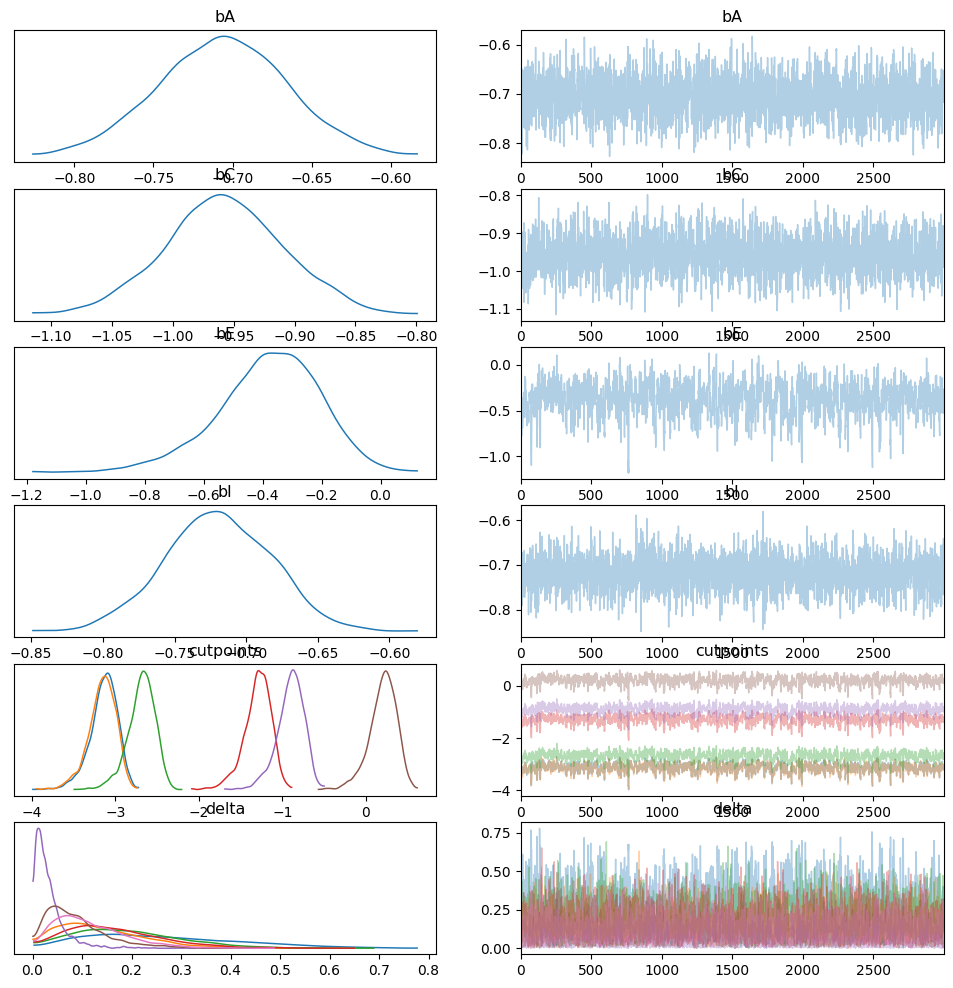

In [39]:
az.plot_trace(az.from_pyro(m12_7))

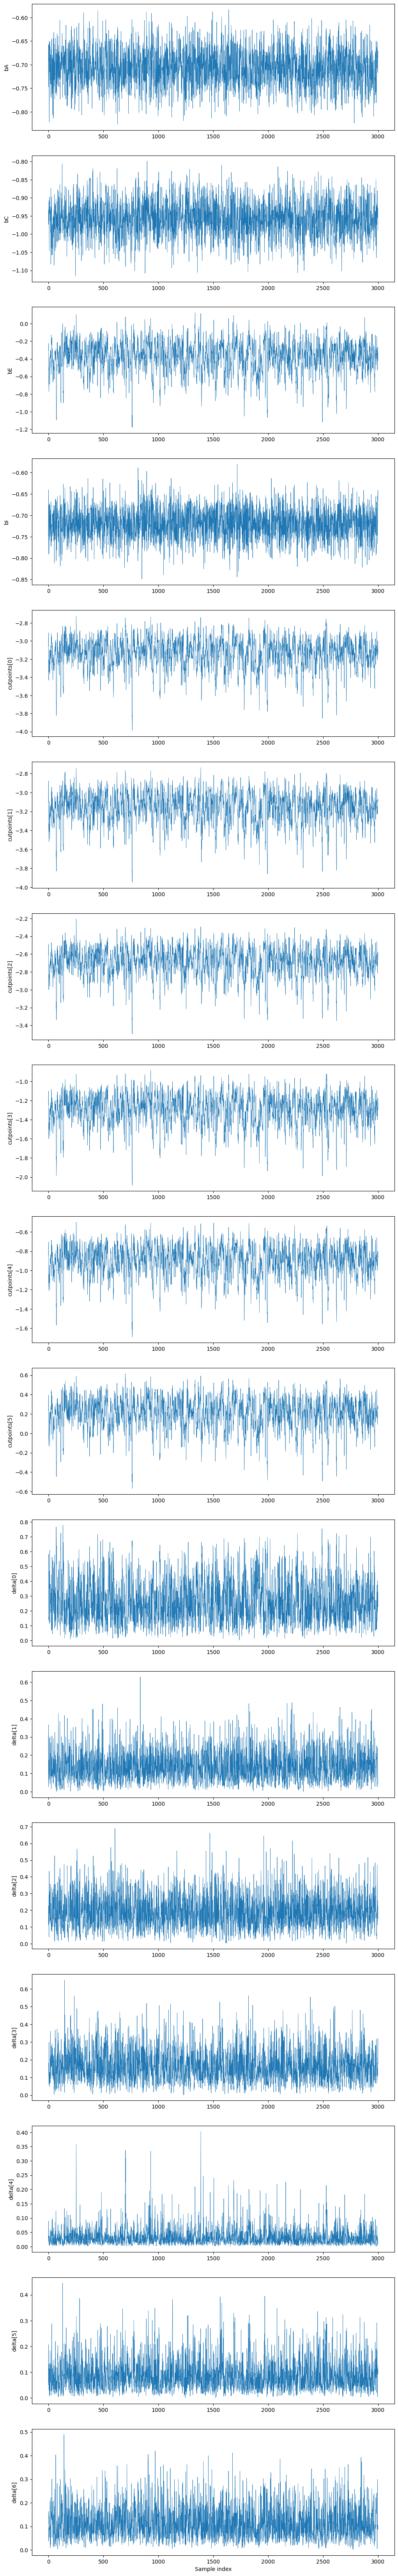

In [40]:
traceplot(unnest_samples(m12_7.get_samples())); plt.show()

## Homework

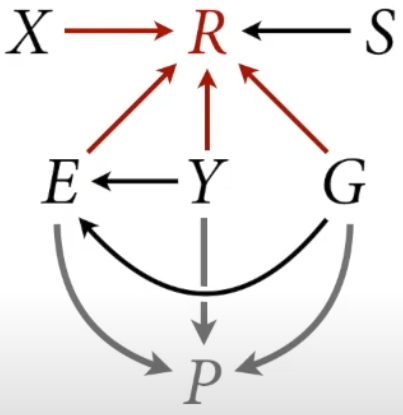

#### Conditioning on Education & Gender
$$\begin{align}
R_i &\sim \text{Ordered-logit}(\phi_i, \kappa) \\
\phi_i &= \beta_{E, G[i]} \sum_{j=0}^{E_i-1} \delta_j + \beta_{A, G[i]} A_i + \beta_{I, G[i]} I_i + \beta_{C, G[i]} C_i \\
\kappa_k &\sim \text{Normal}(0, 1) \\
\beta_\_ &\sim \text{Normal}(0, 0.5) \\
\delta &\sim \text{Dirichlet}(\alpha)
\end{align}$$

#### Conditioning on  Education, Age & Gender
$$\begin{align}
R_i &\sim \text{Ordered-logit}(\phi_i, \kappa) \\
\phi_i &= \beta_{E, G[i]} \sum_{j=0}^{E_i-1} \delta_j + \beta_{A, G[i]} A_i + \beta_{I, G[i]} I_i + \beta_{C, G[i]} C_i + \beta_{Y, G[i]} Y_i \\
\kappa_k &\sim \text{Normal}(0, 1) \\
\beta_\_ &\sim \text{Normal}(0, 0.5) \\
\delta &\sim \text{Dirichlet}(\alpha)
\end{align}$$

If you run the above model you will observe $\beta_{E, G[i]}$ is opposite sign for male and female so we can even index $\delta$ based on gender. 

$$\begin{align}
R_i &\sim \text{Ordered-logit}(\phi_i, \kappa) \\
\phi_i &= \beta_{E, G[i]} \sum_{j=0}^{E_i-1} \delta_{j, G[i]} + \beta_{A, G[i]} A_i + \beta_{I, G[i]} I_i + \beta_{C, G[i]} C_i + \beta_{Y, G[i]} Y_i \\
\kappa_k &\sim \text{Normal}(0, 1) \\
\beta_\_ &\sim \text{Normal}(0, 0.5) \\
\delta_{\_} &\sim \text{Dirichlet}(\alpha)
\end{align}$$